<a href="https://colab.research.google.com/github/sarashahin/Automate-Grading-Test-NART/blob/main/transformer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 1.9 MB/s eta 0:00:00


In [2]:
from sklearn.utils import class_weight
# from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,  ModelCheckpoint
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
from collections import Counter
import pickle
import librosa
import os
import random
from sklearn.utils import resample
from scipy.stats import zscore
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout,BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, MultiHeadAttention, LayerNormalization, Add, Embedding, Bidirectional, Attention, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall, AUC

from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, TimeDistributed, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from keras.layers import MultiHeadAttention

import tensorflow_hub as hub

In [3]:


# Check for TPU availability
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU and single GPU

print("REPLICAS: ", strategy.num_replicas_in_sync)



Running on TPU: 
REPLICAS:  8


In [4]:
def pad_features(features, target_height=128, target_width=431, channels=1):
    padded_features = []
    for feature in features:
        if len(feature.shape) == 2:  # If the feature is 2D, add a channel dimension
            feature = np.expand_dims(feature, axis=-1)  # Add a channel dimension
        padded = np.zeros((target_height, target_width, channels), dtype=feature.dtype)
        height, width = min(feature.shape[0], target_height), min(feature.shape[1], target_width)
        padded[:height, :width, :min(feature.shape[2], channels)] = feature[:height, :width, :min(feature.shape[2], channels)]
        padded_features.append(padded)
    return np.array(padded_features)



In [5]:
def normalize_data(data):
    return data / 255.0

In [6]:
# # Spectrogram-specific augmentation functions
# def random_crop(data, crop_size=(128, 431)):
#     if data.shape[0] < crop_size[0] or data.shape[1] < crop_size[1]:
#         return data
#     start_x = random.randint(0, data.shape[0] - crop_size[0])
#     start_y = random.randint(0, data.shape[1] - crop_size[1])
#     return data[start_x:start_x + crop_size[0], start_y:start_y + crop_size[1]]


# def random_noise(data, noise_factor=0.005):
#     noise = np.random.randn(*data.shape)
#     augmented_data = data + noise_factor * noise
#     augmented_data = np.clip(augmented_data, 0., 1.)
#     return augmented_data

# def augment_data(feature, label, augment=True):
#     if augment:
#         if not isinstance(feature, np.ndarray):
#             raise TypeError(f"Expected np.ndarray for 'feature', but got {type(feature)}")

#         if random.choice([True, False]):
#             # print("Applying random crop")
#             feature = random_crop(feature)
#         else:
#             # print("Applying random noise")
#             feature = random_noise(feature)

#     return feature, label



In [7]:
def data_generator(features, labels, batch_size, input_shape, augment=False):
    num_samples = len(features)
    for i in range(0, num_samples, batch_size):
        batch_features = features[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]

        # Pad the features within the batch to have a consistent shape
        batch_features = pad_features(batch_features, target_height=input_shape[0], target_width=input_shape[1], channels=input_shape[2])

        # Augment data if specified
        augmented_features = []
        for feature, label in zip(batch_features, batch_labels):
            feature, label = augment_data(feature, label, augment=augment)
            augmented_features.append(feature.astype(np.float32))

        batch_features = normalize_data(np.array(augmented_features))
        batch_labels = np.array(batch_labels)

        # Ensure batch size consistency
        if len(batch_features) < batch_size:
            padding_needed = batch_size - len(batch_features)
            batch_features = np.pad(batch_features, [(0, padding_needed)] + [(0, 0), (0, 0), (0, 0)], mode='constant')
            batch_labels = np.pad(batch_labels, [(0, padding_needed)], mode='constant')

        yield batch_features, batch_labels





In [8]:
# Load the full dataset
file_path = '/content/drive/MyDrive/audio_files/processed_data.pkl'
  # Adjust as needed

# Load the dataset
with open(file_path, 'rb') as f:
    features, labels = pickle.load(f)



In [9]:
input_shape = features[0].shape
print(f"Input shape: {input_shape}")

Input shape: (128, 431)


In [10]:
batch_size = 32
input_shape = (128, 431, 1)

# Ensure input shape is consistent
input_shape = features[0].shape + (1,)  # Add channel dimension
print(f"Input shape: {input_shape}")

Input shape: (128, 431, 1)


In [11]:
# Verify the dataset size and label distribution
print(f"Total samples: {len(features)}")
print(f"Label distribution: {Counter(labels)}")

Total samples: 368675
Label distribution: Counter({1: 187304, 0: 181371})


In [12]:
# Display the first 5 features and labels
for i in range(10):
    print(f"Feature {i} shape: {features[i].shape + (1,)}")
    print(f"Feature {i} data:\n{features[i]}")
    print(f"Label {i}: {labels[i]}")

Feature 0 shape: (128, 431, 1)
Feature 0 data:
[[-46.370163 -48.903175 -49.647125 ... -80.       -80.       -80.      ]
 [-43.567207 -45.918953 -42.94165  ... -80.       -80.       -80.      ]
 [-42.273888 -41.396797 -40.10238  ... -80.       -80.       -80.      ]
 ...
 [-67.323364 -62.376892 -58.148674 ... -80.       -80.       -80.      ]
 [-67.51073  -66.18424  -56.762245 ... -80.       -80.       -80.      ]
 [-72.929276 -65.28792  -52.32817  ... -80.       -80.       -80.      ]]
Label 0: 0
Feature 1 shape: (128, 431, 1)
Feature 1 data:
[[-45.28218  -45.6938   -48.01027  ... -80.       -80.       -80.      ]
 [-39.89522  -37.499863 -40.446724 ... -80.       -80.       -80.      ]
 [-38.72726  -34.153408 -32.106667 ... -80.       -80.       -80.      ]
 ...
 [-72.64674  -70.25422  -67.92685  ... -80.       -80.       -80.      ]
 [-71.247314 -68.88309  -72.71805  ... -80.       -80.       -80.      ]
 [-71.65236  -70.11896  -74.45273  ... -80.       -80.       -80.      ]]
Label 1

In [13]:
def check_nan_values(features, labels):
    # Check for NaN values in features
    nan_in_features = 0
    for i, feature in enumerate(features):
        if np.isnan(feature).any():
            nan_in_features += 1
            print(f"Warning: Found NaN values in feature at index {i}.")

    if nan_in_features == 0:
        print("No NaN values in features.")
    else:
        print(f"Total features with NaN values: {nan_in_features}")

    # Check for NaN values in labels
    if np.isnan(labels).any():
        nan_in_labels = np.isnan(labels).sum()
        print(f"Warning: Found {nan_in_labels} NaN values in labels.")
    else:
        print("No NaN values in labels.")

# Apply this check on the data
check_nan_values(features, labels)

No NaN values in features.
No NaN values in labels.


In [14]:
input_shape = (128, 431, 1)


# Stratified splitting of the dataset
train_features, temp_features, train_labels, temp_labels = train_test_split(
    features, labels, test_size=0.3, stratify=labels, random_state=42)

val_features, test_features, val_labels, test_labels = train_test_split(
    temp_features, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

print(f"Training label distribution: {Counter(train_labels)}")
print(f"Validation label distribution: {Counter(val_labels)}")
print(f"Test label distribution: {Counter(test_labels)}")



Training label distribution: Counter({1: 131113, 0: 126959})
Validation label distribution: Counter({1: 28095, 0: 27206})
Test label distribution: Counter({1: 28096, 0: 27206})


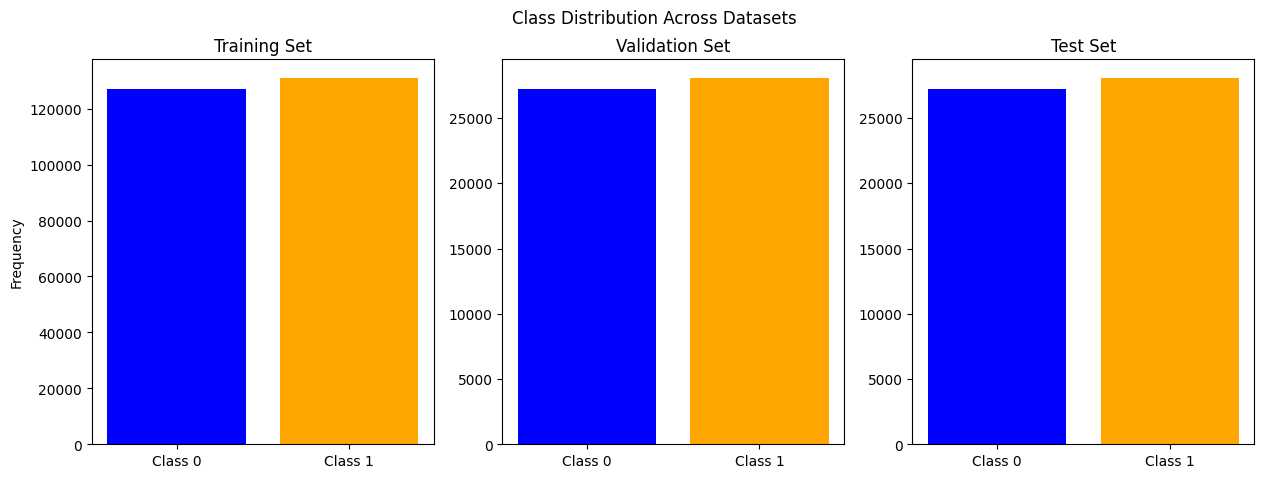

In [15]:
def plot_class_distribution(train_labels, val_labels, test_labels):
    # Count the occurrences of each class in the labels
    train_counts = Counter(train_labels)
    val_counts = Counter(val_labels)
    test_counts = Counter(test_labels)

    labels = ['Class 0', 'Class 1']  # binary classification

    # Plot the distributions
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].bar(labels, [train_counts[0], train_counts[1]], color=['blue', 'orange'])
    ax[0].set_title('Training Set')
    ax[0].set_ylabel('Frequency')

    ax[1].bar(labels, [val_counts[0], val_counts[1]], color=['blue', 'orange'])
    ax[1].set_title('Validation Set')

    ax[2].bar(labels, [test_counts[0], test_counts[1]], color=['blue', 'orange'])
    ax[2].set_title('Test Set')

    plt.suptitle('Class Distribution Across Datasets')
    plt.show()

# Plot the distributions
plot_class_distribution(train_labels, val_labels, test_labels)

In [16]:
def create_tf_dataset(features, labels, batch_size, input_shape, augment=False):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(features, labels, batch_size, input_shape, augment=augment),
        output_signature=(
            tf.TensorSpec(shape=(batch_size, *input_shape), dtype=tf.float32),
            tf.TensorSpec(shape=(batch_size,), dtype=tf.int32)
        )
    )
    dataset = dataset.map(lambda x, y: (x, tf.one_hot(y, depth=2)))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset



In [17]:
# Create datasets
train_dataset = create_tf_dataset(train_features, train_labels, batch_size, input_shape, augment=False).repeat()
val_dataset = create_tf_dataset(val_features, val_labels, batch_size, input_shape, augment=False)
test_dataset = create_tf_dataset(test_features, test_labels, batch_size, input_shape, augment=False)

# Checking a few batches to ensure correctness
for X_batch, y_batch in train_dataset.take(1):
    print(f"Shape of train features in batch: {X_batch.shape}")
    print(f"Shape of train labels in batch: {y_batch.shape}")

for X_batch, y_batch in val_dataset.take(1):
    print(f"Shape of validation features in batch: {X_batch.shape}")
    print(f"Shape of validation labels in batch: {y_batch.shape}")

for X_batch, y_batch in test_dataset.take(1):
    print(f"Shape of test features in batch: {X_batch.shape}")
    print(f"Shape of test labels in batch: {y_batch.shape}")

Shape of train features in batch: (32, 128, 431, 1)
Shape of train labels in batch: (32, 2)
Shape of validation features in batch: (32, 128, 431, 1)
Shape of validation labels in batch: (32, 2)
Shape of test features in batch: (32, 128, 431, 1)
Shape of test labels in batch: (32, 2)


In [ ]:
def get_label_distribution(dataset):
    label_counts = np.zeros(2)  #binary classification with 2 classes
    for _, y_batch in dataset:
        labels = np.argmax(y_batch.numpy(), axis=1)  # Convert one-hot encoded labels back to class indices
        label_counts += np.bincount(labels, minlength=2)
    return label_counts

# Get label distributions for each dataset
train_label_distribution = get_label_distribution(train_dataset)
val_label_distribution = get_label_distribution(val_dataset)
test_label_distribution = get_label_distribution(test_dataset)

# Plot the distributions
labels = ['Class 0', 'Class 1']
x = np.arange(len(labels))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].bar(x, train_label_distribution, color=['blue', 'orange'])
ax[0].set_title('Training Set')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].set_ylabel('Frequency')

ax[1].bar(x, val_label_distribution, color=['blue', 'orange'])
ax[1].set_title('Validation Set')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)

ax[2].bar(x, test_label_distribution, color=['blue', 'orange'])
ax[2].set_title('Test Set')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)

plt.suptitle('Label Distribution Across Datasets')
plt.show()

KeyboardInterrupt: 

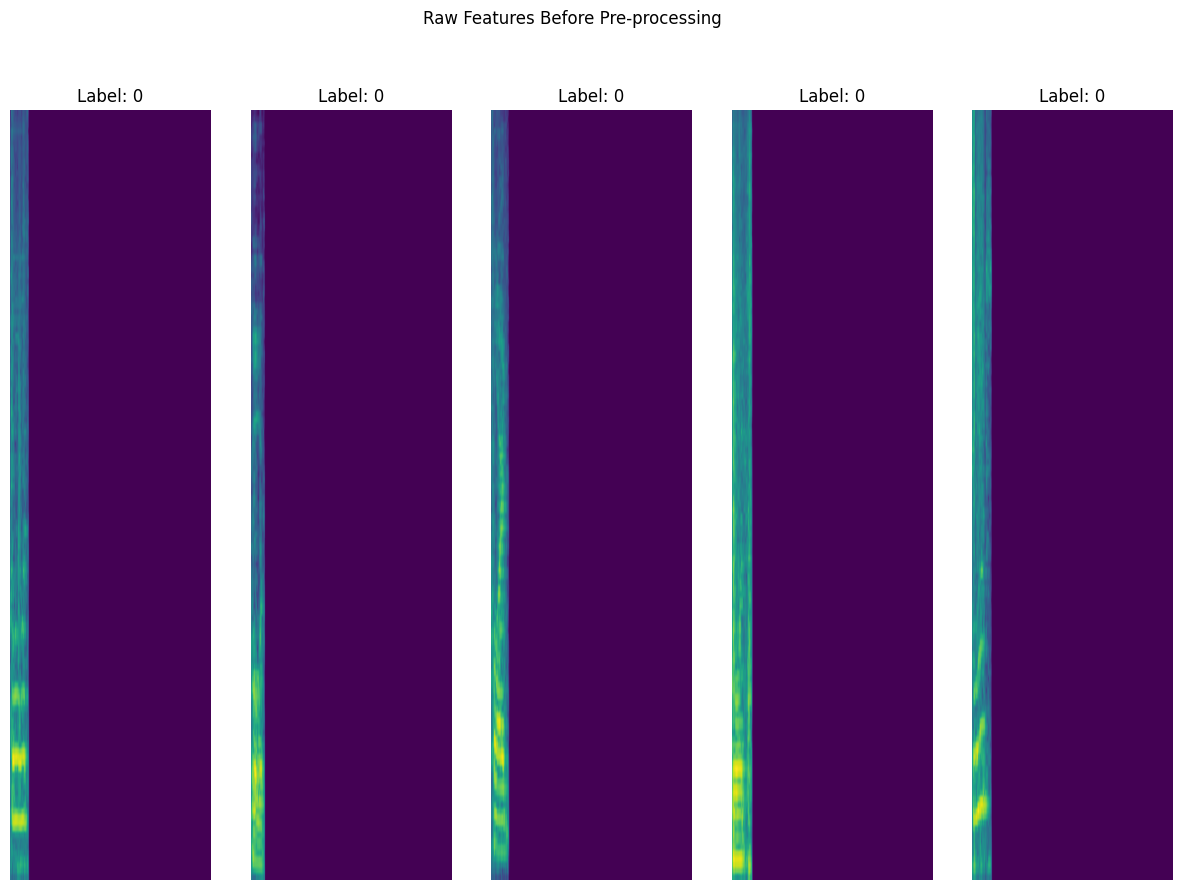

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot raw features (spectrogram)
def plot_raw_features(features, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(features[i].squeeze(), aspect='auto', origin='lower')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.suptitle('Raw Features Before Pre-processing')
    plt.show()

# Visualize a few samples of raw features
plot_raw_features(features, labels)


In [19]:
def check_for_nan_inhomogeneous(array):
    for i, sub_array in enumerate(array):
        if isinstance(sub_array, np.ndarray):
            if np.isnan(sub_array).any():
                print(f"NaN values found in sub-array at index {i}.")
        else:
            print(f"Sub-array at index {i} is not a NumPy array.")
    print("Check complete.")

check_for_nan_inhomogeneous(features)

Check complete.


In [20]:
#  Build Transformer model
def create_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # Feature extraction
    x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal(),
               kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = TimeDistributed(Flatten())(x)

    # Transformer block
    attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LSTM(128, return_sequences=True)(attn_output)
    x = Dropout(0.4)(x)
    x = LSTM(128)(x)
    x = Dropout(0.4)(x)

    # Dense layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

    return model

In [23]:
# Strategy scope for TPU or multi-GPU usage
with strategy.scope():
    # Model creation
    model = create_transformer_model(input_shape)

    # Callbacks for training
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4, verbose=1)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/audio_files/best_attention_transformer_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

    # Add custom callback to print batch shapes
    # print_batch_shape = PrintBatchShapeCallback()


    num_samples = 368675  # actual number of samples in dataset
    batch_size = 32
    steps_per_epoch = len(train_features) // batch_size


    # Training
    model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,  # Total number of epochs
        steps_per_epoch=steps_per_epoch,
        callbacks=[reduce_lr, early_stopping, model_checkpoint],
        verbose=1
    )

Epoch 1/10
8064/8064 [==============================] - ETA: 0s - loss: 0.6100 - accuracy: 0.7302 - precision: 0.7302 - recall: 0.7302 - auc: 0.8061
Epoch 1: val_loss improved from inf to 0.48495, saving model to /content/drive/MyDrive/audio_files/best_attention_transformer_model.h5
8064/8064 [==============================] - 561s 67ms/step - loss: 0.6100 - accuracy: 0.7302 - precision: 0.7302 - recall: 0.7302 - auc: 0.8061 - val_loss: 0.4849 - val_accuracy: 0.8121 - val_precision: 0.8121 - val_recall: 0.8121 - val_auc: 0.8867 - lr: 1.0000e-04
Epoch 2/10
8064/8064 [==============================] - ETA: 0s - loss: 0.5028 - accuracy: 0.7974 - precision: 0.7974 - recall: 0.7974 - auc: 0.8735
Epoch 2: val_loss improved from 0.48495 to 0.47536, saving model to /content/drive/MyDrive/audio_files/best_attention_transformer_model.h5
8064/8064 [==============================] - 526s 65ms/step - loss: 0.5028 - accuracy: 0.7974 - precision: 0.7974 - recall: 0.7974 - auc: 0.8735 - val_loss: 0.47

In [24]:
# Evaluate model on the test
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
print(f'Test loss: {test_loss}, accuracy: {test_acc}, precision: {test_precision}, recall: {test_recall}, auc: {test_auc}')



1729/1729 [==============================] - 36s 20ms/step - loss: 0.5183 - accuracy: 0.7970 - precision: 0.7970 - recall: 0.7970 - auc: 0.9077
Test loss: 0.5183225870132446, accuracy: 0.7969744205474854, precision: 0.7969744205474854, recall: 0.7969744205474854, auc: 0.9077298641204834


In [25]:
#Predict on the test
test_predictions = model.predict(test_dataset)

# Convert predictions to the class labels
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Convert one-hot encoded test labels back to class labels
test_labels_classes = np.argmax([label for _, label in test_dataset], axis=1)



1729/1729 [==============================] - 34s 17ms/step


1729/1729 [==============================] - 29s 16ms/step
Mismatch: 55328 labels vs 55328 predictions
              precision    recall  f1-score   support

     class 0       0.71      1.00      0.83     27232
     class 1       1.00      0.60      0.75     28096

    accuracy                           0.80     55328
   macro avg       0.85      0.80      0.79     55328
weighted avg       0.86      0.80      0.79     55328



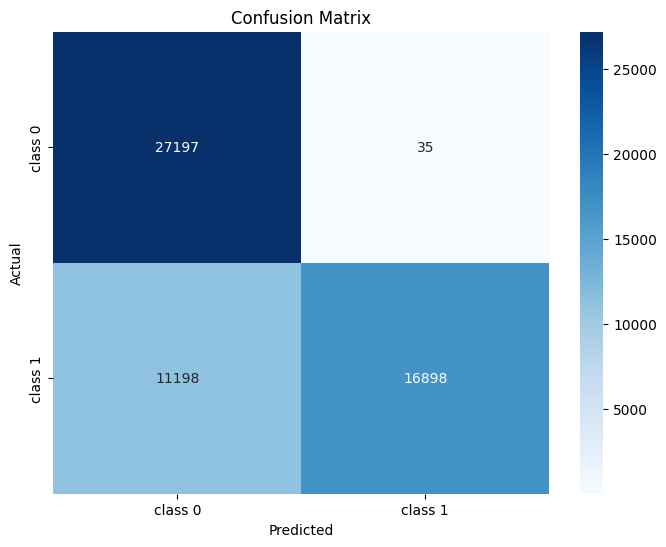

In [26]:

# Predict on the test
test_predictions = model.predict(test_dataset)

# Convert predictions to the class labels
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Flatten the test labels
test_labels_classes = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_dataset])

# the length of labels and predictions match
print(f"Mismatch: {len(test_labels_classes)} labels vs {len(test_predictions_classes)} predictions")

min_length = min(len(test_labels_classes), len(test_predictions_classes))
test_labels_classes = test_labels_classes[:min_length]
test_predictions_classes = test_predictions_classes[:min_length]

#Generate classification report
target_names = ['class 0', 'class 1']
report = classification_report(test_labels_classes, test_predictions_classes, target_names=target_names)

print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels_classes, test_predictions_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()








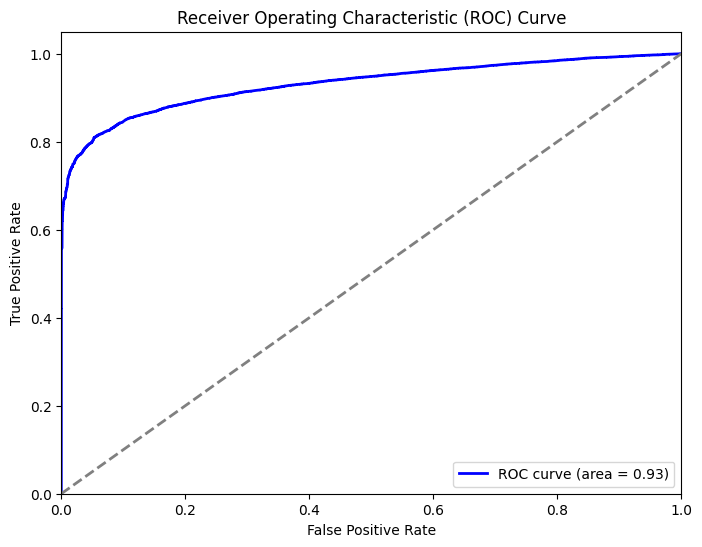

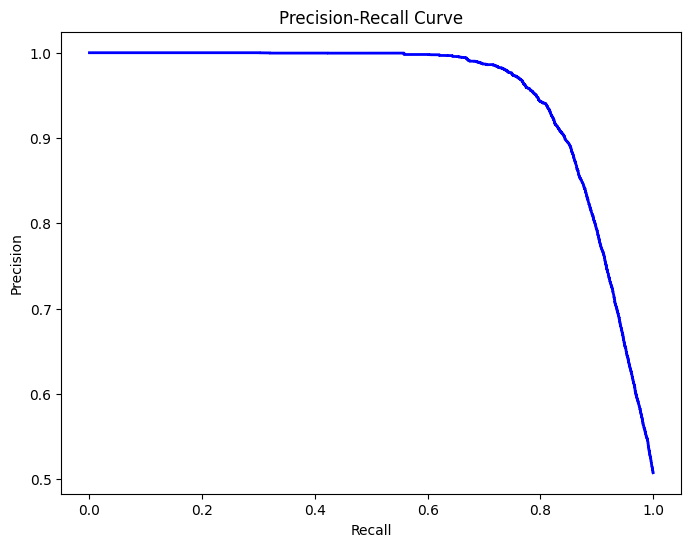

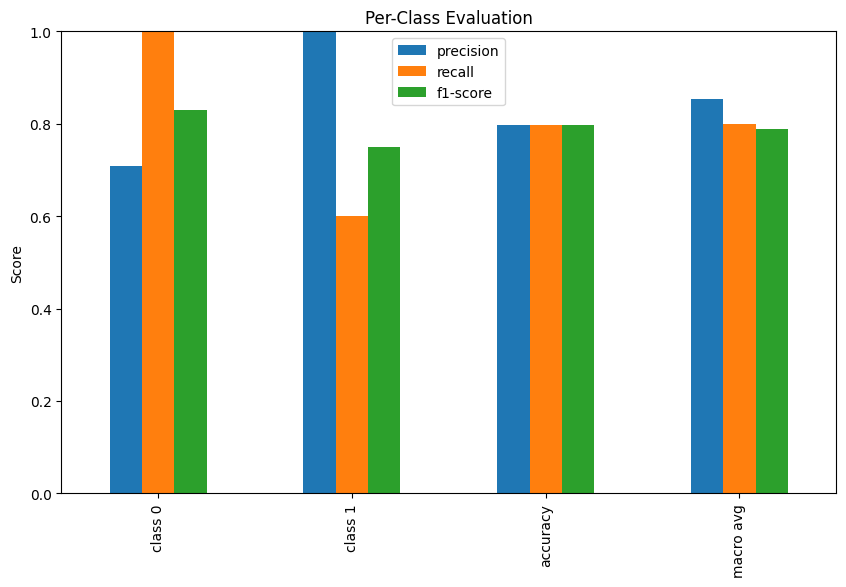

In [27]:
#ROC Curve
fpr, tpr, _ = roc_curve(test_labels_classes, test_predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_labels_classes, test_predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

#Per-Class Precision, Recall, F1-Score
metrics = classification_report(test_labels_classes, test_predictions_classes, target_names=target_names, output_dict=True)

metrics_df = pd.DataFrame(metrics).transpose()

metrics_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 6))
plt.title('Per-Class Evaluation')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

In [28]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.1 MB/s eta 0:00:00


Matthews Correlation Coefficient:  0.6510576884902328
Logarithmic Loss:  0.4580119263992494


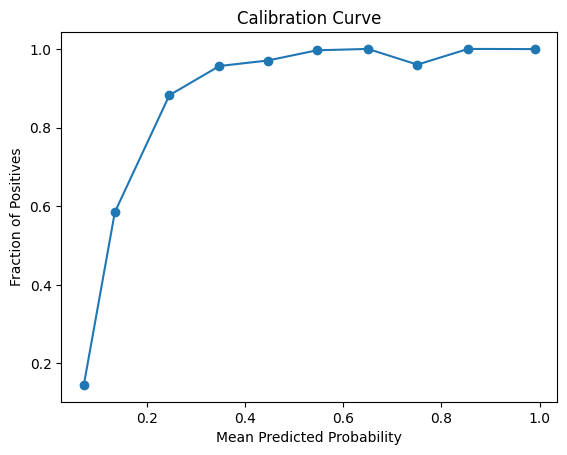

In [29]:
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, log_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
# import shap

# Evaluate MCC
print("Matthews Correlation Coefficient: ", matthews_corrcoef(test_labels_classes, test_predictions_classes))
print("Logarithmic Loss: ", log_loss(test_labels_classes, test_predictions))

# Plot Calibration Curve
prob_true, prob_pred = calibration_curve(test_labels_classes, test_predictions[:, 1], n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.show()

# # Convert features to NumPy arrays
# train_features = np.array(train_features)
# test_features = np.array(test_features)

# SHAP Values
# explainer = shap.KernelExplainer(model.predict, train_features[:100])  # Using a small sample for efficiency
# shap_values = explainer.shap_values(test_features[:10])  # Use a small sample for explanation
# shap.summary_plot(shap_values, test_features[:10])



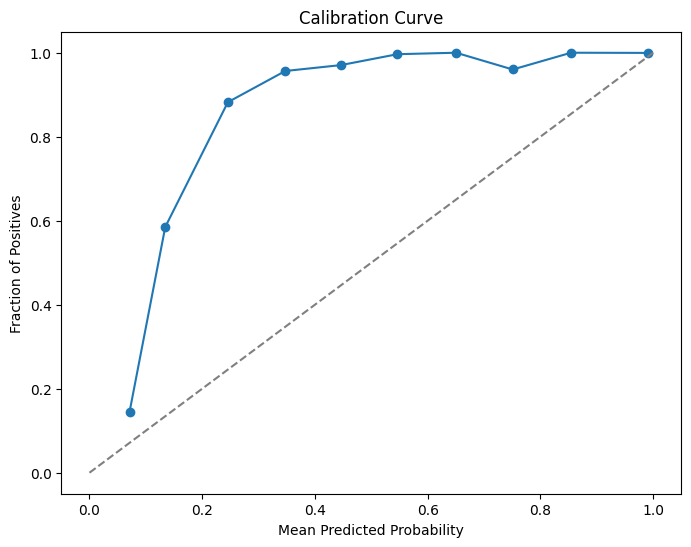

In [30]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(test_labels_classes, test_predictions[:, 1], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.show()

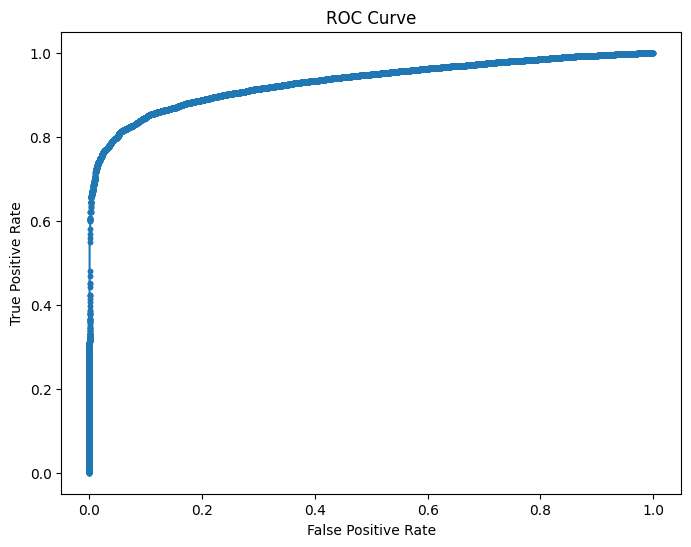

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_labels_classes, test_predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


**Evaluating on unseen data**

In [32]:
#extract mel-spectrogram features from audio file
def extract_mel_spectrogram(file_path: str, n_mels: int = 128, fmax: int = 8000, chunk_duration: int = 5) -> tuple:
    y, sr = librosa.load(file_path, sr=None)
    if len(y) == 0:
        print(f"Warning: {file_path} contains no data")
    features = []
    num_chunks = (len(y) + chunk_duration * sr - 1) // (chunk_duration * sr)  # Calculate the number of chunks
    for start in range(0, len(y), chunk_duration * sr):
        chunk = y[start:start + chunk_duration * sr]
        if len(chunk) < chunk_duration * sr:
            chunk = np.pad(chunk, (0, chunk_duration * sr - len(chunk)))
        S = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=n_mels, fmax=fmax)
        S_dB = librosa.power_to_db(S, ref=np.max)
        features.append(S_dB)
    # print(f"extract_mel_spectrogram: {len(features)} features, {num_chunks} chunks for file {file_path}")
    return features, num_chunks



In [34]:
from tensorflow.keras.models import load_model

# Load the best model from the training process
model = load_model('/content/drive/MyDrive/audio_files/best_attention_transformer_model.h5')


In [35]:
#preprocess new audio files
def preprocess_new_audio(file_path):
    features, _ = extract_mel_spectrogram(file_path)
    padded_features = pad_features(features)
    normalized_features = normalize_data(padded_features)
    return normalized_features


In [36]:
# Load and preprocess an unseen audio file
unseen_audio_file = '/content/drive/MyDrive/audio_files/Dataset_2_Cleaned/50_CAMPANILE/P35.wav'
processed_data = preprocess_new_audio(unseen_audio_file)

#processed data has the correct shape
processed_data = np.expand_dims(processed_data, axis=0)  # Add batch dimension if needed

# If processed_data shape is (1, 1, 128, 431, 1), reshape it to (1, 128, 431, 1)
if processed_data.shape[1] == 1:
    processed_data = processed_data.squeeze(axis=1)  # Remove the extra dimension

# Predict using the model
prediction = model.predict(processed_data)

# Convert the prediction to the corresponding class label
predicted_label = np.argmax(prediction, axis=-1)

print(f"Predicted label: {predicted_label}")


1/1 [==============================] - 1s 804ms/step
Predicted label: [1]
